## 2019 2nd ML month with KaKR
[TEAM - EDA] 2019-03-11 ~ 
- [updated] 3.12 데이터상의 중복이슈가 발생해서 그 부분 수정하고 다시 돌립니다. 
- [updated] 4.03 데이터가 바껴서 기존과 설명 달랐던 부분 수정 
    - 데이터가 바껴서 설명하고 좀 다른 부분 수정 + correlation 코드 수정
    - 변수에 대한 탐색을 좀 더 심화 
    - 선형회귀 가정 추가 + 뒷 부분 모델을 해석력 있는 DT와 OLS로 수정
    - 변수들끼리의 관계 파악 
    - 피쳐엔지니어링 부분 상세한 설명 추가 
- [updated] 4.09 다양한 모델을 추가하여 성능을 높임 
    - LGB / XGB / CAT with Log, not Log 

## 목차 
### - 데이터 탐색
    - 문제 정의
    - 변수 설명
    - 시각화 
    - 이상치 및 결측치 확인
    - 유니크 갯수
### - 데이터 전처리
    - 이상치 및 결측치 처리
    - 정규화
### - 변수 생성
### - 모델링 
    - 회귀
    - GBM ( LGB/XGB )
    - 앙생블 
### - 잔차분석 

## 1. 데이터 탐색
### 1.1 문제 정의 
이번 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제 입니다. 

평가로는 RMSE를 사용합니다. 

비슷한 대회로는 데이콘에서 열린 [직방 모델링 대회](https://dacon.io/cpt4)와 캐글에서 열린 [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)가  있습니다. 



In [1]:
# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

In [3]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


훈련과 평가 데이터의 크기는 15000과 6500으로 적은편이고 비율은 5:2 로 심하게 불균등하지는 않습니다. 변수의 갯수가 20개로 적은편이서 좋은 피쳐를 만들어 내는것이 모델성능에 관건으로 생각됩니다. 

### 1.2 변수설명
변수 설명은 상혁님의 커널을 참고하였습니다  : https://www.kaggle.com/cookierhkwk/eda-house-price-prediction
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : Has been viewed
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있

In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date의 경우 yyyy-mm-dd + T000000의 형태로 저희가 필요한 부분은 앞의 8자리 입니다. 
- bathrooms의 경우 소숫점의 값이 보이는데, 이는 미국의 기준에 따른 것입니다. 자세한 내용은 아래 부분에 나옵니다. 
- yr_renovated의 경우 0의 값이 보이는데, 0년도에 재건축이 되었다는 의미가 아니라 재건축을 하지 않았다는 의미입니다. 
- sqft_living 과 sqft_living15처럼 비슷한 값이 보입니다. 둘은 15년도를 기준으로 크기 계산의 기준에 따라 다른 값을 보입니다. 둘의 차이가 꽤 큰 부분도 있어서 이를 잘 활용해야 할 것 같습니다. 

head를 통해서는 이 정도로 가볍게 변수를 이해해보고 하나하나 변수를 살펴보면서 전처리해야 할 부분과 피쳐 엔지니어링을 할 아이디어를 고민해보겠습니다. 

### 1.3 변수 시각화 ( 목적변수 )

목적변수 price의 경우 *집을 구매한 시점* 의 가격입니다. 이 말은 현재의 가격을 반영하는게 아니라는 말과 같습니다. 집을 산 이후 리모델링을 통해 집을 고쳤어도 집의 가격에는 영향을 주지 못합니다. 

참고 : https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83957

In [5]:
#descriptive statistics summary
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

목적변수의 경우 min과 max의 차이가 크고, std가 굉장히 큰 편입니다. 아래의 그림을 보면 더 명확하겠지만 왼쪽으로 분포가 굉장히 치우친 것을 알 수 있습니다. 

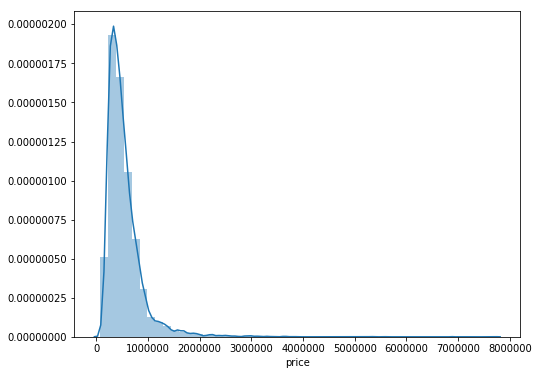

In [6]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [7]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


- 왜도 : 오른쪽 꼬리가 길수록 값이 더 큽니다. 
- 첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 간주 할 수 있습니다. 

위의 목적변수의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. 저는 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주겠습니다. 

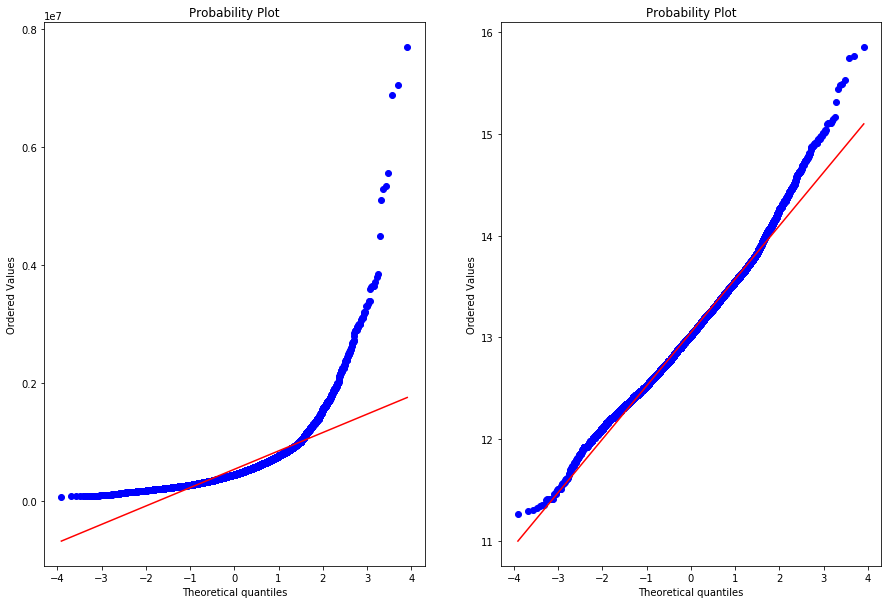

In [8]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

log를 취해주면 기존보다 더 정규성을 가지는 것을 확인할 수 있습니다. 

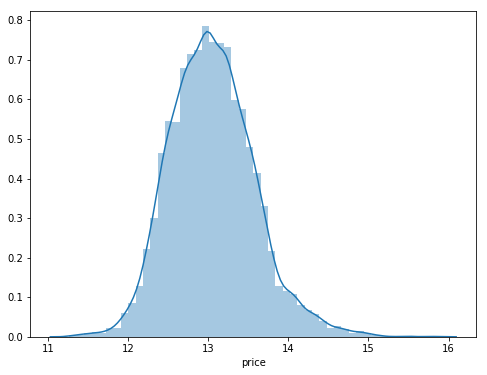

In [9]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

### 1.3 변수시각화 ( 반응변수 )
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용 

아래는 목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다. 전부 보는 것이 아니라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 하겠습니다. 

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


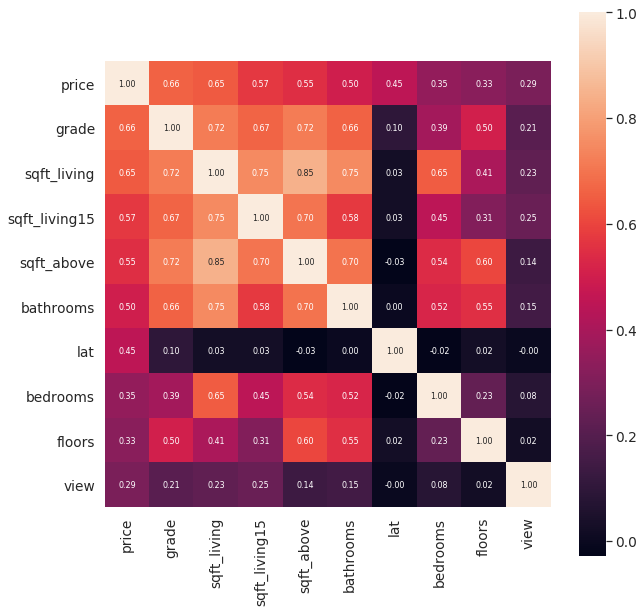

In [10]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

목적변수와 상관도가 높은 변수는 집의 등급 - 주거공간의 크기 - 전체 크기순이고 재미있게 lat이라는 위도 값이 들어있습니다. 위도가 증가함에 따라 가격이 왜 증가하는지 ? 이것을 어떻게 활용할 수 있는지는 좀 더 탐색이 필요해보입니다. 

--- 
2019-03-12 +) 위에서 lat의 경우 price와 상관성이 높은 것을 볼 수 있었습니다. 카톡방과 [Discussion](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83549)에 따르면, 위의 지역은 시애틀인데 시애틀은 북쪽으로 갈 수록 살기 좋은 집들이 많다고 합니다. 

이 부분에 대해서 [김태진님의 커널](https://www.kaggle.com/fulrose/map-visualization-with-folium-ing)의 자료에서 나온 부분을 보면 더 자세하게 인사이트를 얻을 수 있습니다. 

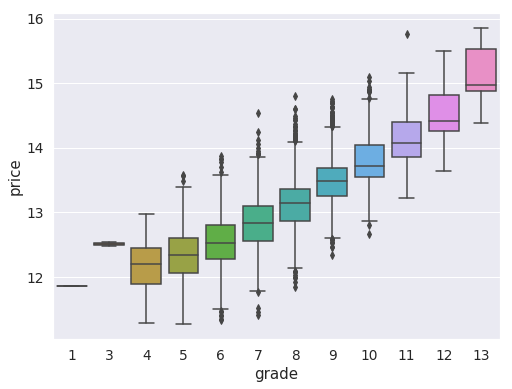

In [11]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade의 경우 *"1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." * 라고 합니다. 

집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만 
- ***등급 3의 경우 값이 큰 이유***
- ***등급 7,8,9에서 이상치가 많은 이유*** 
- ***등급 8과 11에서 차이가 큰 이상치가 나타나는 이유***

위의 3가지는 좀 더 자세히 살펴봐야 합니다. 

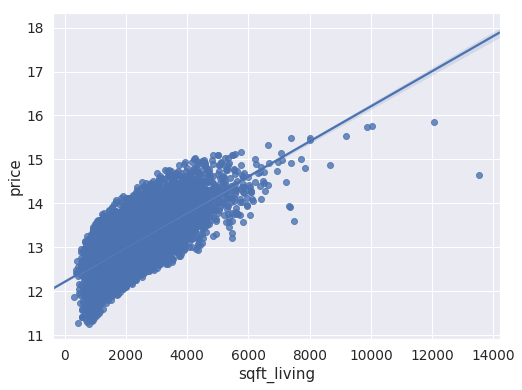

In [12]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

### sqlf_living / sqlf_lot
(주거 평방 피트 / 부지 평방 피트)

1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다. 

*즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.*

전반적으로 선형성을 보이지만 가격이 14~15사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)으로 생각되어집니다. 제거할지 말지는 저 값을 확인해보고 결정하겠습니다. 

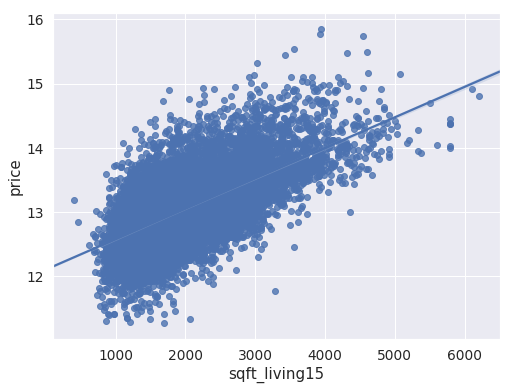

In [13]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다. 아무래도 재건축으로 인한 영향일 것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 FE이 필요해 보입니다. 

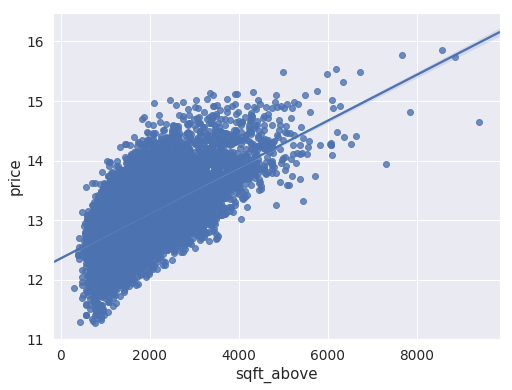

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

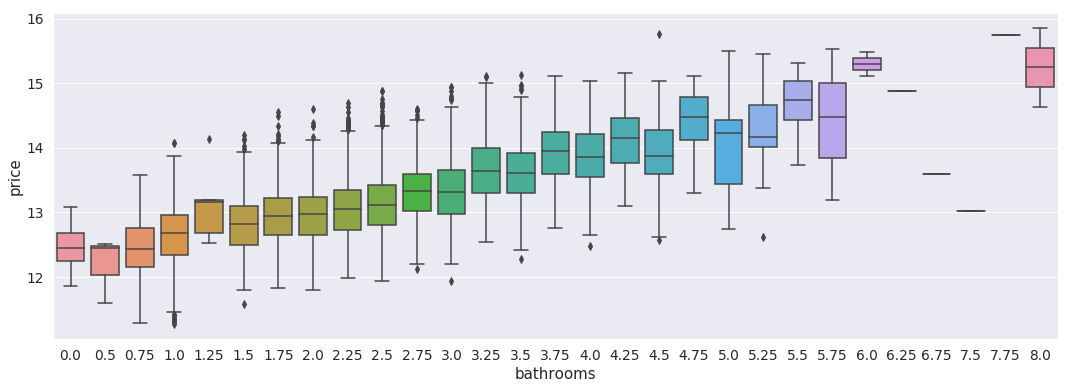

In [15]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다. 
- 0.5 : 세면대, 화장실 
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조 

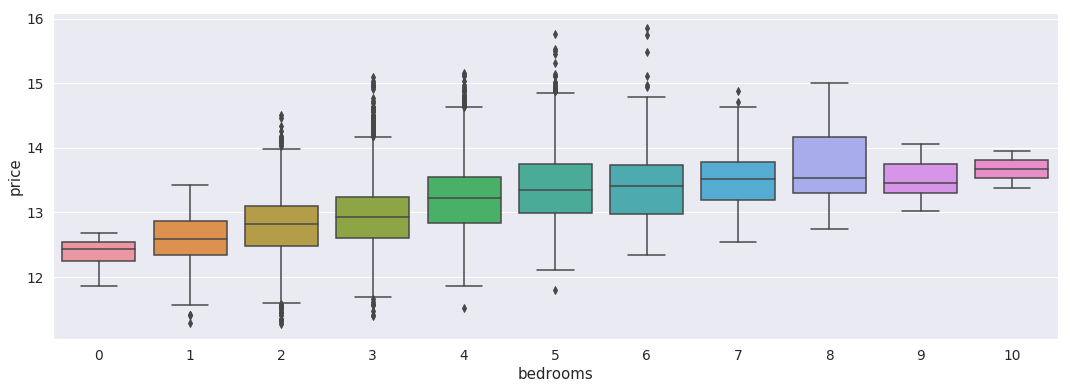

In [16]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

방의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 띄는것을 볼 수 있습니다. 그리고 방의 갯수가 2~6의 경우 방이 적음에도 값이 큰 값들이 많습니다. 이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.  

### 1.4 결측치 

In [17]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

#https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-nn-approach
def mis_value_graph(data):  
    data = [
    go.Bar(
        x = data.columns,
        y = data.isnull().sum(),
        name = 'Counts of Missing value',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
    layout= go.Layout(
        title= '"Total Missing Value By Column"',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='skin')
    
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

df_all = pd.concat([df_train,df_test])
del df_all['price']
mis_value_graph(df_all)

다행히도 위의 결측치 그래프를 보면 결측치가 없는 상황입니다. 

### 1.5 유니크한 갯수

In [18]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

view의 유니크갯수가 5인걸로 보니 grade같이 순위형변수로 생각되어지고 waterfront의 경우는 2개로 있다/없다는 상징하는 것 같습니다. 위에서 몇몇 값들을 자세히 살펴보면, 

In [19]:
df_train['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

층수의 경우 1.5, 2.5, 3.5와 같이 소숫점을 가집니다. 이는 미국에서 흔히 볼 수 있는 형태로 다락방을 끼고 있는 형태로 생각하시면 됩니다. 

## 2. 데이터 전처리 
### 2.1 이상치 제거 
위에서 중요한 변수들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다. 
- sqft_living, grade, bedrooms 

#### 2.1.1 sqft_living

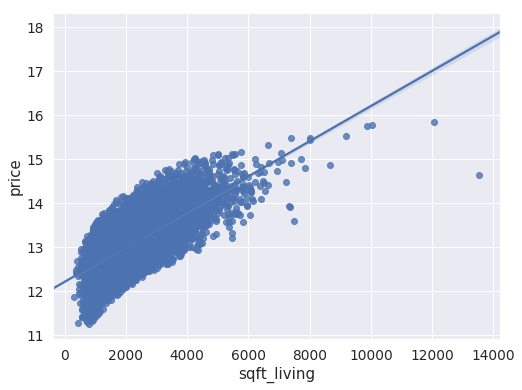

In [20]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [21]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


위의 값을 봤을 때, 다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다. 추가적으로 price와 상관성이 높은 `grade`와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 하겠습니다. 

In [22]:
df_train = df_train.loc[df_train['id']!=8990]

#### 2.1.2 grade

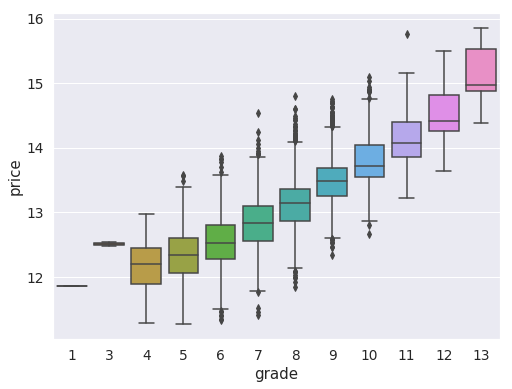

In [23]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [24]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다. 

In [25]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [26]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 3값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다. 

In [27]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

#### 2.1.3 bedrooms 

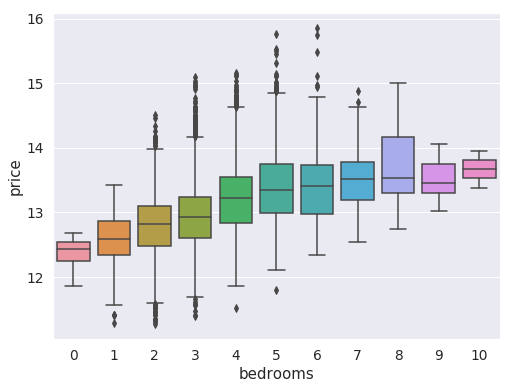

In [28]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

침실의 수를 보면 위에서 한 얘기와 마찬가지로 median이 양의 상관관계를 띄고 있습니다. 그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있습니다. 가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.  

### 2.2 정규화 
코드는 다음의 링크를 활용하였습니다. 
https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline

In [29]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

### 2.3 변수 수정

In [30]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

## 3. 변수 생성

In [31]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [32]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

아래는 집값 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것 입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다 !!!

In [33]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

## 4. 모델링
### 4.1 단순 선형회귀 

In [34]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [35]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.746e+06
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:21:26   Log-Likelihood:                -7.7075
No. Observations:               15029   AIC:                             65.42
Df Residuals:                   15004   BIC:                             255.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
date             2.112e-06   2.01e-07     

모델의 설명력을 보면 1로 굉장히 높지만, 각각의 변수들 중에서는 p-value가 높은 값들이 있음을 확인할 수 있습니다. 그러한 이유를 생각해보면 FE해서 나온 파생변수들은 기존의 변수와 연관되어있고 sqft_로 시작하는 변수들끼리의 상관성등이 있어서 다중공선성의 문제를 가지기 때문입니다. 실제로 다중공선성을 체크하기 위해 vif를 이용한 확인을 하면 


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.294167e+06
1,date,4.284045e+06
18,long,2.057338e+06
17,lat,2.441371e+05


보통의 경우 10 이상이면 다중공선성이 존재한다고 말하는데, 위의 식에서는 waterfront, view, sqft_lot15, is_renovated 4가지 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있습니다. 

이를 해결하기 위한 방안으로는 
- 다중공선성에 robust한 트리모델을 사용하는 방법
- 변수제거 및 FE, 변환등을 통한 대체 
- 관측값을 늘려 표본의 크기를 증가 

하지만 마지막 3의 방안은 실현이 불가능하고 선형회귀를 사용할거면 2를 최대한 활용하고, 그렇지 않을 경우에는 1번 방안을 사용하면 됩니다. 

### 4.2 LightGBM

In [37]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.140213	valid_1's rmse: 0.156479
[1000]	training's rmse: 0.12132	valid_1's rmse: 0.153266
[1500]	training's rmse: 0.108498	valid_1's rmse: 0.152476
Early stopping, best iteration is:
[1532]	training's rmse: 0.107807	valid_1's rmse: 0.152436
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.139454	valid_1's rmse: 0.159584
[1000]	training's rmse: 0.120951	valid_1's rmse: 0.155715
[1500]	training's rmse: 0.108324	valid_1's rmse: 0.154778
Early stopping, best iteration is:
[1675]	training's rmse: 0.10468	valid_1's rmse: 0.154593
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.139666	valid_1's rmse: 0.162345
[1000]	training's rmse: 0.120823	valid_1's rmse: 0.158677
[1500]	training's rmse: 0.108296	valid_1's rmse: 0.157806
Early stopping, best iteration is:
[1712]	training's rmse: 0.103862	valid_1's rmse: 0.157685
Training until 

In [38]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115804.90550499351


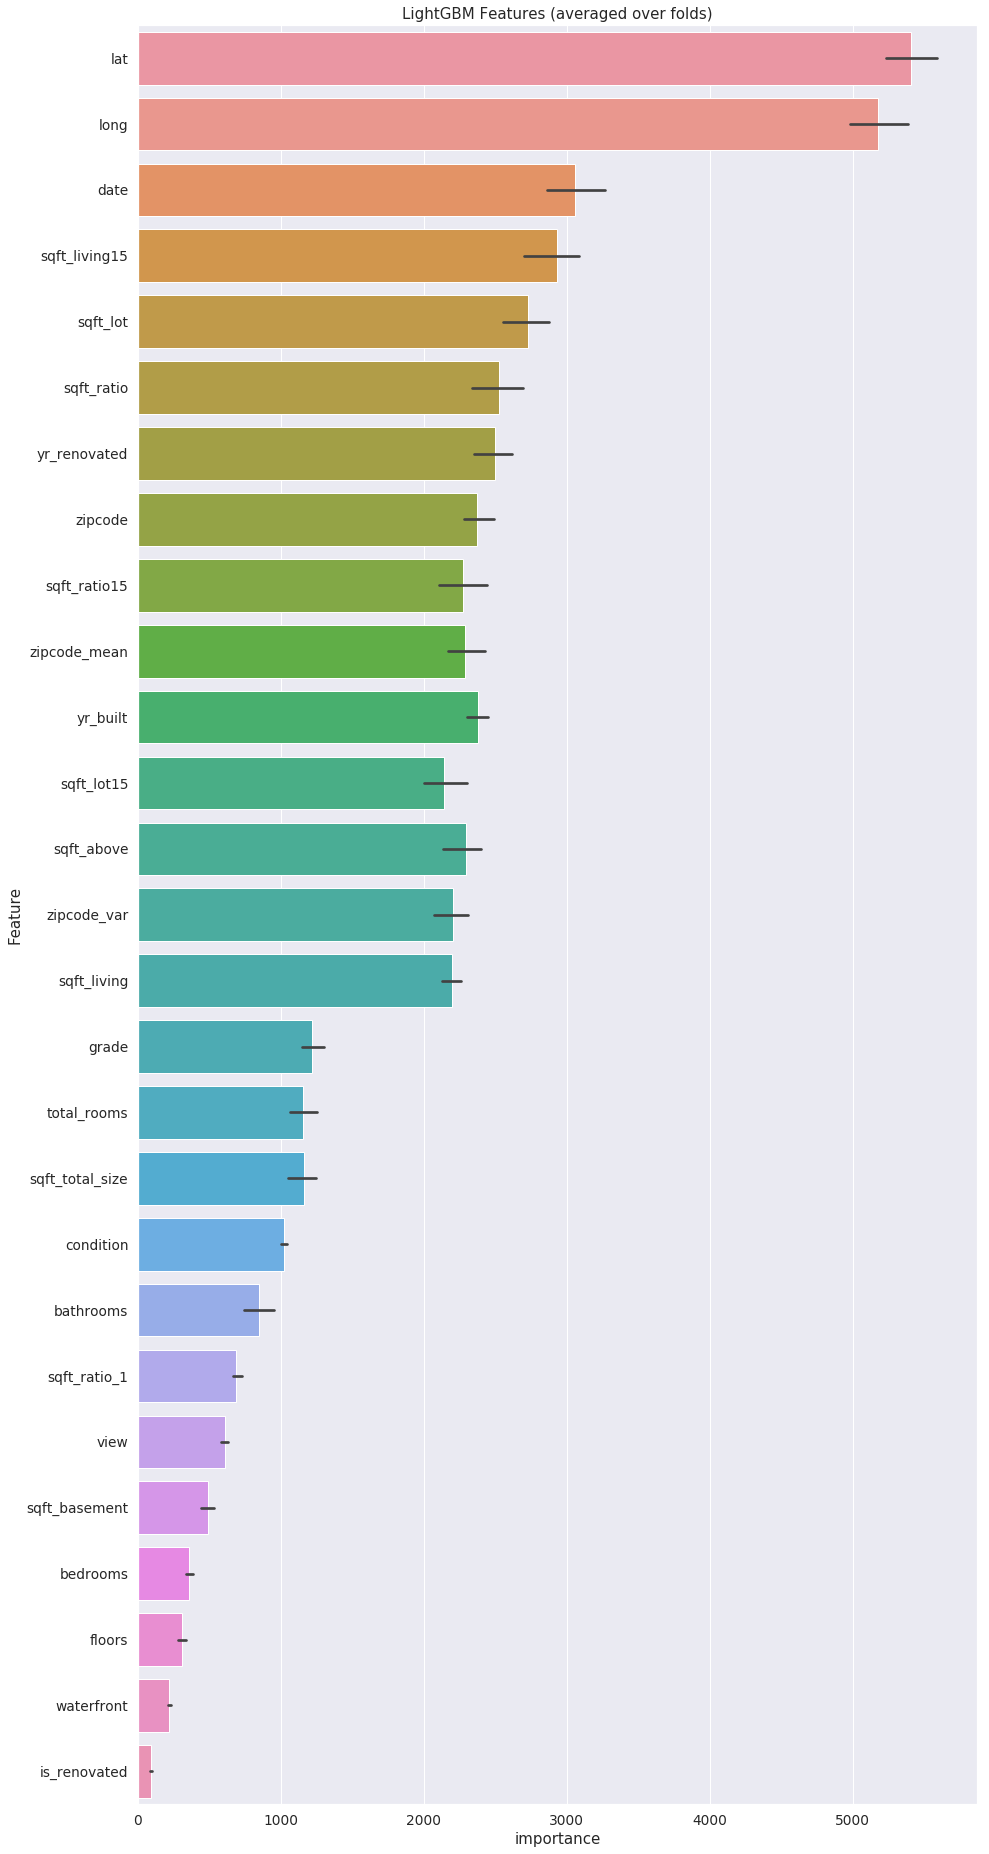

In [39]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

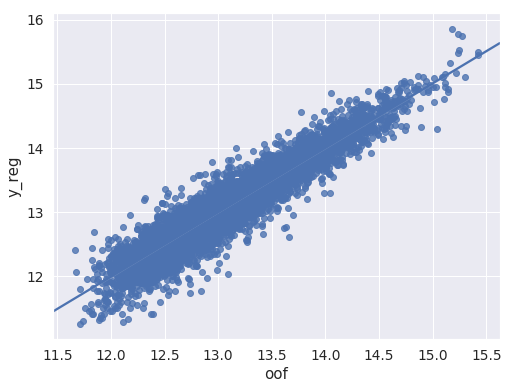

In [40]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

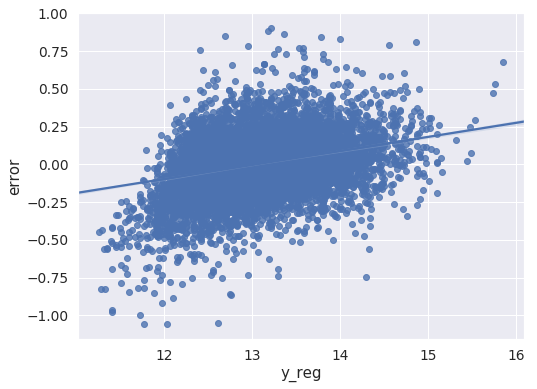

In [41]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

실제 y_reg와 error와의 관계를 보면 잔차가 독립적이지 않는것을 볼 수 있습니다. 13~14부근은 error가 0에 가깝습니다. 하지만 15 이상은 더 높게 예측을 하는 경향을 보이고, 12이하는 더 낮게 예측하는 경향을 보입니다. 

이를 개선하기 위해서는 
- 15이상에서 크게 예측한 이유
- 12이하에서 작게 예측하는 이유 
- error가 0.5 이상인 값들의 이유 

3가지 관점에서 접근을 해야 합니다. 

# Ensemble

In [42]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115804.90550499351


In [43]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 135765	valid_1's rmse: 134510
[1000]	training's rmse: 110764	valid_1's rmse: 123459
[1500]	training's rmse: 99594.5	valid_1's rmse: 121419
[2000]	training's rmse: 91339.1	valid_1's rmse: 120813
Early stopping, best iteration is:
[1972]	training's rmse: 91746.8	valid_1's rmse: 120785
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 135029	valid_1's rmse: 134189
[1000]	training's rmse: 110380	valid_1's rmse: 116980
[1500]	training's rmse: 99994.2	valid_1's rmse: 114077
Early stopping, best iteration is:
[1763]	training's rmse: 95615.2	valid_1's rmse: 113686
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 133909	valid_1's rmse: 142725
[1000]	training's rmse: 109917	valid_1's rmse: 124875
[1500]	training's rmse: 99281.9	valid_1's rmse: 120597
[2000]	training's rmse: 91866.6	valid_1's rmse: 119075
[2500]	training's rmse: 86013.2	val

In [44]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124644.4521727238


In [45]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:12.4339	test-rmse:12.4339
[500]	train-rmse:0.177716	test-rmse:0.195745
[1000]	train-rmse:0.127723	test-rmse:0.164408
[1500]	train-rmse:0.112265	test-rmse:0.161416
[2000]	train-rmse:0.100967	test-rmse:0.160237
[2500]	train-rmse:0.0919117	test-rmse:0.159717
[3000]	train-rmse:0.084132	test-rmse:0.159398
best num_boost_rounds =  3398


In [46]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:650025	test-rmse:650059
[500]	train-rmse:84167.1	test-rmse:134607
[1000]	train-rmse:67855.1	test-rmse:128561
[1500]	train-rmse:58679.7	test-rmse:126910
[2000]	train-rmse:52367.9	test-rmse:126118
[2500]	train-rmse:47726.3	test-rmse:125685
[3000]	train-rmse:43833.9	test-rmse:125420
[3500]	train-rmse:40630.5	test-rmse:125220
[4000]	train-rmse:37860.5	test-rmse:125089
[4500]	train-rmse:35563.7	test-rmse:125017
[5000]	train-rmse:33503.1	test-rmse:124946
[5500]	train-rmse:31621.2	test-rmse:124872
[6000]	train-rmse:29926.4	test-rmse:124829
best num_boost_rounds =  6242


In [47]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115695.02136234193


In [48]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [49]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [50]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission.csv",index=False)